In [216]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [217]:
CLUSTER = "WEBSTER"

In [218]:
df = pd.read_csv("../predictions/predictions_TGCN_sparkling-leaf-4.csv", index_col=0, parse_dates=["Date"])
df.head()
df = df.loc[:, (df.columns.str.startswith(CLUSTER) | (df.columns == "Date"))]

<Axes: xlabel='Date'>

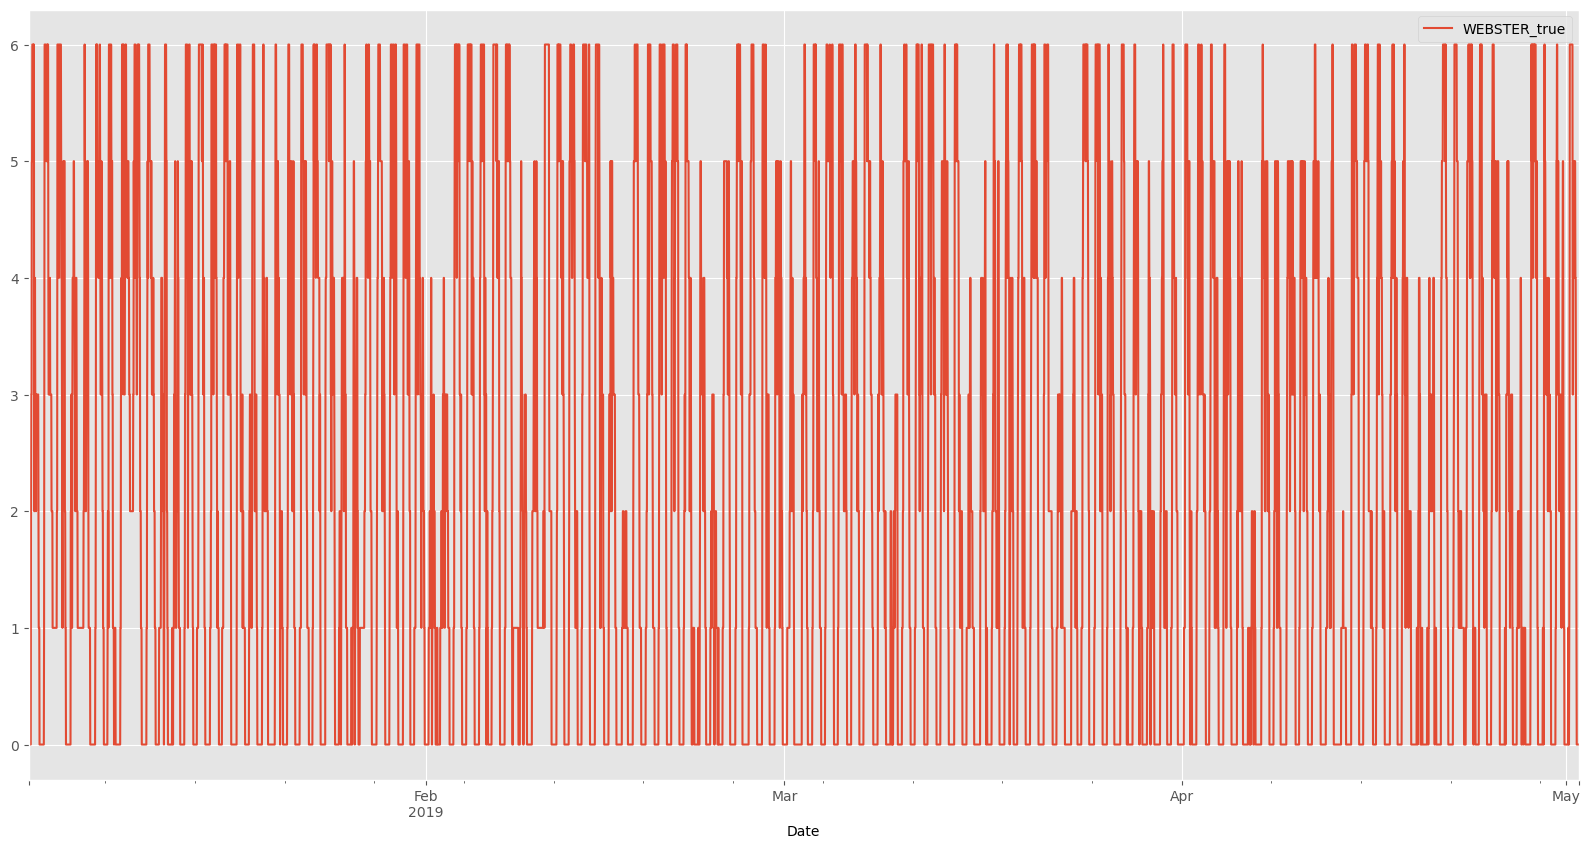

In [219]:
df.plot(x="Date", y=CLUSTER+'_true', figsize=(20, 10))

<Axes: xlabel='Date'>

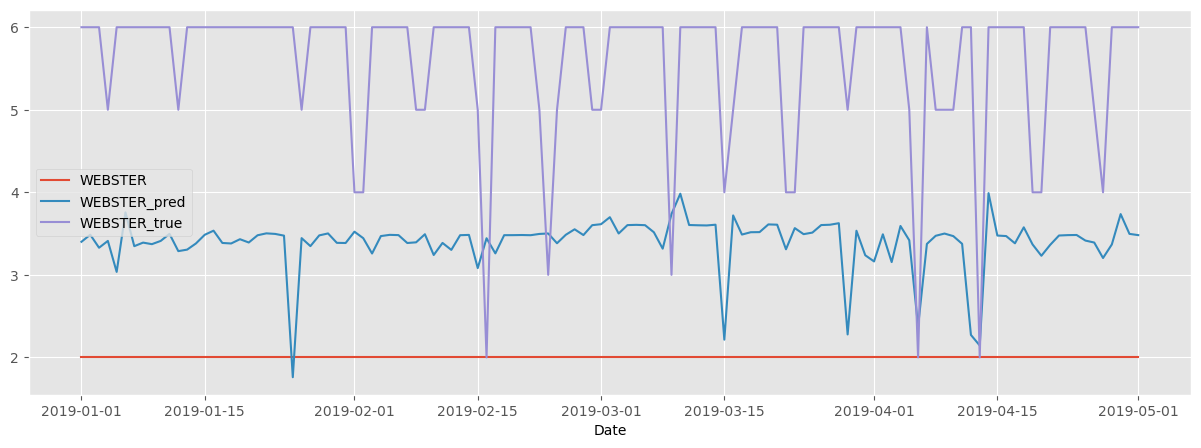

In [220]:
# find the highest predictions for each day
df.groupby(df["Date"].dt.date)[['WEBSTER', 'WEBSTER_pred', 'WEBSTER_true']].max().plot(figsize=(15, 5))

In [221]:
# We should provide tau from the model training
df['tau_true'] = df['WEBSTER_true'].max()
df['tau_pred'] = df['WEBSTER_pred'].max()
df['tau_censored'] = df['WEBSTER'].max()

sessions_per_day = df.groupby(df["Date"].dt.date).sum()[['WEBSTER', 'WEBSTER_pred', 'WEBSTER_true', 'tau_true', 'tau_pred', 'tau_censored']].copy()
sessions_per_day['utilisation_true'] = sessions_per_day['WEBSTER_true'] / sessions_per_day['tau_true']
sessions_per_day['utilisation_pred'] = sessions_per_day['WEBSTER_pred'] / sessions_per_day['tau_pred']
sessions_per_day['utilisation_censored'] = sessions_per_day['WEBSTER'] / sessions_per_day['tau_censored']
sessions_per_day.head()

,WEBSTER,WEBSTER_pred,WEBSTER_true,tau_true,tau_pred,tau_censored,utilisation_true,utilisation_pred,utilisation_censored
Date,,,,,,,,,
2019-01-01,61.0,64.621308,110.0,282.0,187.522840,94.0,0.390071,0.344605,0.648936
2019-01-02,69.0,67.345115,135.0,288.0,191.512688,96.0,0.468750,0.351648,0.718750
2019-01-03,75.0,78.131437,157.0,288.0,191.512688,96.0,0.545139,0.407970,0.781250
2019-01-04,58.0,57.972161,88.0,288.0,191.512688,96.0,0.305556,0.302707,0.604167
2019-01-05,58.0,43.327027,90.0,288.0,191.512688,96.0,0.312500,0.226236,0.604167


In [222]:
sessions_per_day[sessions_per_day.WEBSTER > sessions_per_day.tau_true]

,WEBSTER,WEBSTER_pred,WEBSTER_true,tau_true,tau_pred,tau_censored,utilisation_true,utilisation_pred,utilisation_censored
Date,,,,,,,,,


<Axes: xlabel='Date'>

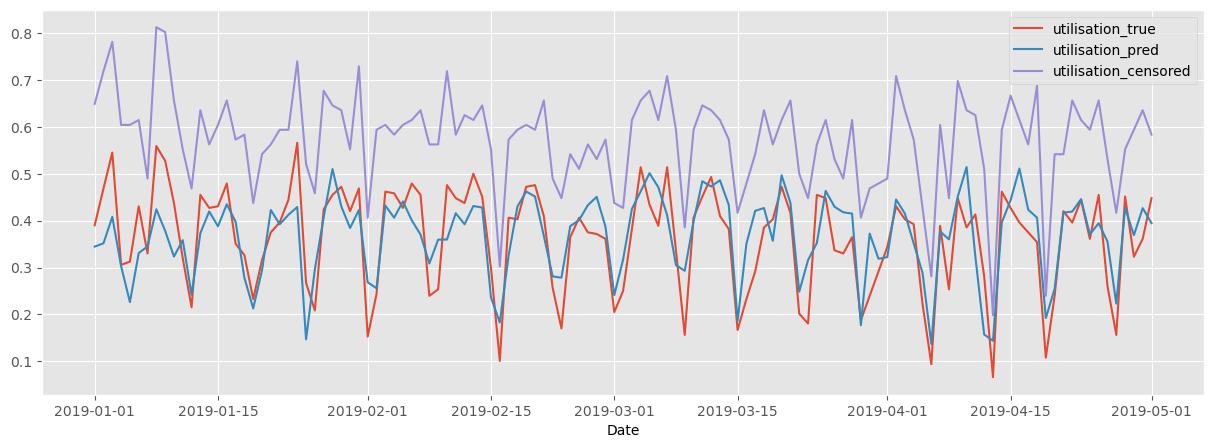

In [223]:
sessions_per_day[['utilisation_true', 'utilisation_pred', 'utilisation_censored']].plot(figsize=(15, 5))

In [224]:
max_tau = 10
df.drop(columns=['tau_true', 'tau_pred', 'tau_censored'], inplace=True)


In [225]:
df_censored = df.filter(regex=f"^{CLUSTER}$|Date").copy()
df_pred = df.filter(regex=f"^{CLUSTER}_pred$|Date").copy()
df_true = df.filter(regex=f"^{CLUSTER}_true$|Date").copy()

In [233]:
def calculate_utility(df, CLUSTER, max_tau):
    """ 
    Calulcate the utility for a given cluster, given predictions, censored and true values of usage, for taus from 1 - max_tau.
    """
    df_util = df.copy()
    util_values = {level: [] for level in [f"{CLUSTER}_pred", f"{CLUSTER}_true", CLUSTER]}
    # calculate the utility for predicted usage, true usage and censored usage, for each tau
    for level, util_list in util_values.items():
        for tau_hypothetical in range(1, max_tau + 1):
            # clip the values to the hypothetical tau (we use values from df instead of df_util to avoid clipping the values multiple times)
            df_util[level] = df[level].clip(upper=tau_hypothetical)
            # add the tau_hypothetical as a column
            df_util[f'tau_{tau_hypothetical}'] = tau_hypothetical
            # Sum the half-hourly values to get the daily values
            tmp = df_util.groupby(df_util["Date"].dt.date)[[CLUSTER, f'tau_{tau_hypothetical}']].sum()
            # calculate the utility per day
            tmp['utilisation'] = (tmp[CLUSTER] / tmp[f'tau_{tau_hypothetical}'])
            # add the mean utility to the list
            util_list.append(tmp['utilisation'].mean())

    return util_values
utility_values = calculate_utility(df, CLUSTER, max_tau)
utility_values

{'WEBSTER_pred': [1.1446793857335442,
  0.5723396928667721,
  0.3815597952445148,
  0.28616984643338605,
  0.22893587714670888,
  0.1907798976222574,
  0.1635256265333635,
  0.14308492321669303,
  0.12718659841483826,
  0.11446793857335444],
 'WEBSTER_true': [1.1446793857335442,
  0.5723396928667721,
  0.3815597952445148,
  0.28616984643338605,
  0.22893587714670888,
  0.1907798976222574,
  0.1635256265333635,
  0.14308492321669303,
  0.12718659841483826,
  0.11446793857335444],
 'WEBSTER': [0.6435400914366097,
  0.5723396928667721,
  0.3815597952445148,
  0.28616984643338605,
  0.22893587714670888,
  0.1907798976222574,
  0.1635256265333635,
  0.14308492321669303,
  0.12718659841483826,
  0.11446793857335444]}

In [228]:
np.array(vals).shape
df_utilisation = pd.DataFrame(np.array(vals).T, columns=cols)
df_utilisation['capacity'] = df_utilisation.index + 1
df_utilisation

,WEBSTER_pred,WEBSTER_true,WEBSTER,capacity
0,0.643540,0.643540,0.643540,1
1,0.321770,0.321770,0.321770,2
2,0.214513,0.214513,0.214513,3
3,0.160885,0.160885,0.160885,4
4,0.128708,0.128708,0.128708,5
5,0.107257,0.107257,0.107257,6
6,0.091934,0.091934,0.091934,7
7,0.080443,0.080443,0.080443,8
8,0.071504,0.071504,0.071504,9
9,0.064354,0.064354,0.064354,10


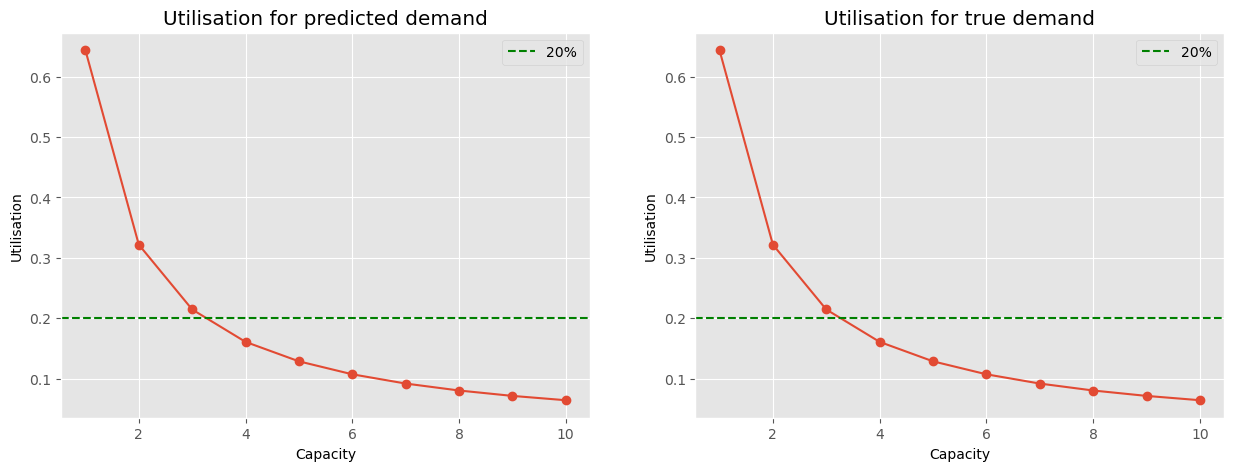

In [232]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(df_utilisation['capacity'], df_utilisation[f"{CLUSTER}_pred"], '-o')
axs[0].set_title("Utilisation for predicted demand")

axs[1].plot(df_utilisation['capacity'], df_utilisation[f"{CLUSTER}_true"], '-o')
axs[1].set_title("Utilisation for true demand")

for ax in axs:
    ax.axhline(y=0.2, linestyle='--', color='g', label="20%")
    ax.set_xlabel("Capacity")
    ax.set_ylabel("Utilisation")
    ax.legend()

plt.show()